In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchview import draw_graph
import os

from common import h5dataset, onnxexporter, model_dnn, trainer


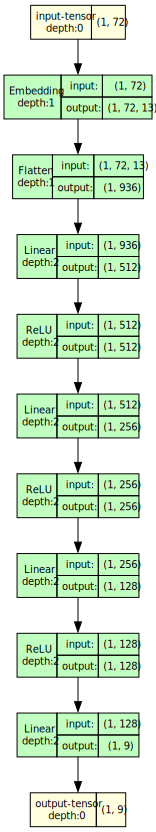

In [2]:
# Plot model graph
model = model_dnn.ModelDNN(
    name="Jass",
    input_size=72,
    embedding_size=13,
    hidden_size=[512, 256, 128],
    output_size=9,
)
model_graph = draw_graph(model, torch.zeros(1, 72).long(), show_shapes=True)
model_graph.visual_graph

In [3]:
DATASET_PATH = '../log_parser/dataset/flat_playing.hdf5'
if not os.path.exists(DATASET_PATH):
    raise FileNotFoundError(f"Dataset not found at {DATASET_PATH}")

MODLE_PATH = './models/play'
if not os.path.exists(MODLE_PATH):
    os.makedirs(MODLE_PATH)

LOGS_PATH = './logs/play'
if not os.path.exists(LOGS_PATH):
    os.makedirs(LOGS_PATH)

In [4]:
BATCH_SIZE = 256
NUM_EPOCHS = 20
LEARNING_RATE = 1e-3
SEED = 42

torch.manual_seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load dataset
dataset = h5dataset.H5Dataset(DATASET_PATH)
train_dataset, val_dataset = dataset.split(0.8)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=8)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=8)

model_sizes = [
    [256, 128],
    [512, 256],
    [1024, 512],
    [256, 128, 64],
    [512, 256, 128],
    [1024, 512, 256],
    [256, 128, 64, 32],
    [512, 256, 128, 64],
    [1024, 512, 256, 128]
]

accuracy_fn = lambda y_pred, y_true: (y_pred.argmax(dim=1) == y_true).float().mean()
loss_fn = lambda y_pred, y_true: F.nll_loss(F.log_softmax(y_pred, dim=1), y_true)

# set up trainer
trainer = trainer.Trainer(
    train_loader=train_loader,
    val_loader=val_loader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn,
    model_path=MODLE_PATH,
    device=device
)

Using device: cuda


In [ ]:
# train the model
for model_size in model_sizes:
    model = model_dnn.ModelDNN(
        name="JassPlay",
        input_size=72,
        embedding_size=13,
        hidden_size=model_size,
        output_size=9,
    ).to(device)
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    trainer.train(NUM_EPOCHS, model, optimizer)

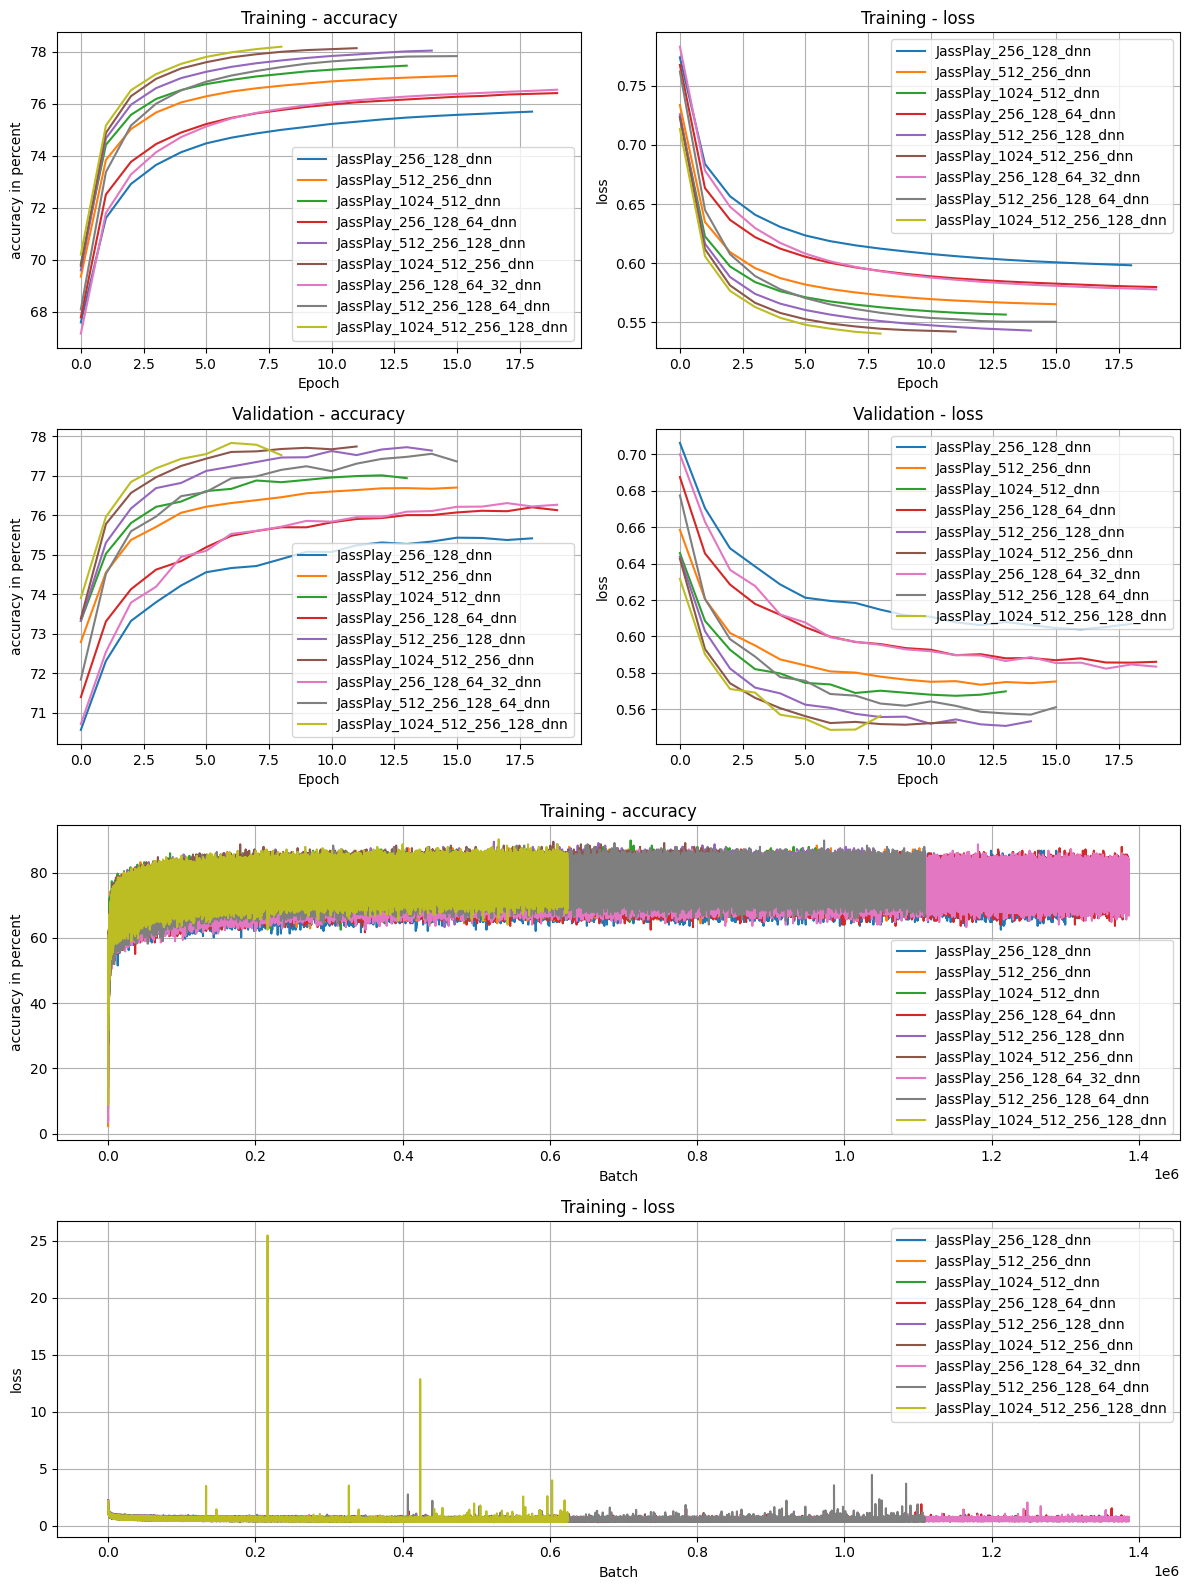

In [ ]:
# create graphs
trainer.monitor.plot()

In [7]:
trainer.monitor.dump(dump_path=LOGS_PATH, filename="monitor")

In [8]:
# export the model to ONNX

model = model_dnn.ModelDNN(
    name="JassPlay",
    input_size=72,
    embedding_size=13,
    hidden_size=[512, 256, 128],
    output_size=9,
)
ONNX_PATH = f"{MODLE_PATH}/{model.name}.onnx"
model.load_state_dict(torch.load(f"{MODLE_PATH}/{model.name}.pth"))
onnxexporter.onnx_exporter(
    model=model,
    decision_fn=F.log_softmax,
    in_dim=72,
    output_path=ONNX_PATH
)

Exporting model to ONNX format...
Successfully converted and saved ONNX model to ./models/play/JassPlay_512_256_128_dnn.onnx
